# PPO

## Definition

## PPO 推导
![image.png](demo/img_1.png)
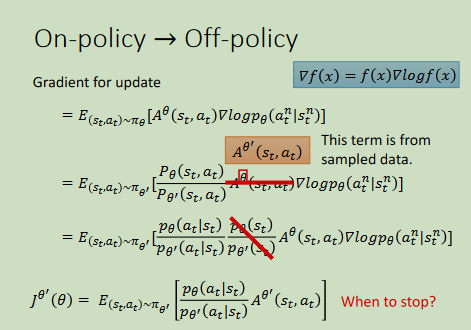

> 其中$\Delta logp_{\theta}(a_t^n|s_t^n) = \frac{\Delta p_{\theta}(a_t^n|s_t^n)}{p_{\theta}(a_t^n|s_t^n)}$ 

In [3]:
from typing import Optional, Tuple
from collections import namedtuple
import torch
import numpy as np

ppo_policy_data = namedtuple('ppo_policy_data', ['logit_new', 'logit_old', 'action', 'adv', 'weight'])
ppo_policy_loss = namedtuple('ppo_policy_loss', ['policy_loss', 'entropy_loss'])
ppo_info = namedtuple('ppo_info', ['approx_kl', 'clipfrac'])


def ppo_policy_error(data: namedtuple, clip_ratio: float = 0.2, dual_clip: Optional[float] = None) -> Tuple[namedtuple, namedtuple]:
    logit_new, logit_old, action, adv, weight = data
    if weight is None:
        weight = torch.ones_like(adv)

    dist_new = torch.distributions.categorical.Categorical(logits=logit_new)
    dist_old = torch.distributions.categorical.Categorical(logits=logit_old)
    logp_new = dist_new.log_prob(action)
    logp_old = dist_old.log_prob(action)

    entropy_loss = (dist_new.entropy()*weight).mean()
    ratio = torch.exp(logp_new - logp_old)
    
    surr1 = ratio*adv
    surr2 = ratio.clamp(1 - clip_ratio, 1 + clip_ratio) * adv # clip 并不改变目标的正负，只是改变调整的速率

    # adv < 0 进行双重裁剪
    if dual_clip is not None:
        clip1 = torch.min(surr1, surr2)
        clip2 = torch.max(clip1, dual_clip * adv)
        policy_loss = -(torch.where(adv < 0, clip2, clip1) * weight).mean()

    else:
        policy_loss = (-torch.min(surr1, surr2) * weight).mean()

    # for logging
    with torch.no_grad():
        approx_kl = (logp_old - logp_new).mean().item()
        clipped = ratio.gt(1 + clip_ratio) | ratio.lt(1 - clip_ratio)
        clipfrac = torch.as_tensor(clipped).float().mean().item()

    return ppo_policy_loss(policy_loss, entropy_loss), ppo_info(approx_kl, clipfrac)


In [4]:
def test_ppo(clip_ratio, dual_clip):
    B, N = 4, 32
    logit_new = torch.randn(B, N).requires_grad_(True)
    logit_old = logit_new + torch.rand_like(logit_new) * 0.1
    action = torch.randint(0, N, size=(B, ))
    adv = torch.rand(B)
    data = ppo_policy_data(logit_new, logit_old, action, adv, None)
    loss, info = ppo_policy_error(data, clip_ratio=clip_ratio, dual_clip=dual_clip)

    assert all([np.isscalar(i) for i in info])
    assert logit_new.grad is None
    total_loss = sum(loss)
    total_loss.backward()
    assert isinstance(logit_new.grad, torch.Tensor)


In [5]:
test_ppo(clip_ratio=0.2, dual_clip=0.2)